# Cats vs Dogs (Kaggle)
https://www.kaggle.com/c/dogs-vs-cats/

## Carregar imagens do diretório

In [1]:
import os
current_dir = os.path.abspath(os.getcwd())

## Converter base de dados para treino, validação e teste

In [2]:
#cria nova pasta para cachorros e gatos atendendo a estrutura do Keras/Tensorflow
folder = "\\cats_and_dogs_dataset"
train_folder = current_dir + folder + "\\train"
val_folder = current_dir + folder + "\\validation"
test_folder = current_dir + folder + "\\test"

# Fazer o Tensorflow carregar as imagens para a RNA

In [3]:
import tensorflow as tf

print(tf.__version__)
print(tf.config.list_physical_devices('GPU'))

2.6.1
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
from tensorflow.keras.utils import image_dataset_from_directory

train_dataset = image_dataset_from_directory(train_folder,
                                             image_size=(180, 180),
                                             batch_size=32)

validation_dataset = image_dataset_from_directory(val_folder,
                                                  image_size=(180, 180),
                                                  batch_size=32)

test_dataset = image_dataset_from_directory(test_folder,
                                            image_size=(180, 180),
                                            batch_size=32)

Found 17501 files belonging to 2 classes.
Found 2448 files belonging to 2 classes.
Found 5051 files belonging to 2 classes.


In [5]:
for data_batch, labels_batch in train_dataset:
    print("data batch shape:", data_batch.shape)
    print("labels batch shape:", labels_batch.shape)
    print(data_batch[0].shape)
    break

data batch shape: (32, 180, 180, 3)
labels batch shape: (32,)
(180, 180, 3)


# Exemplo de Data Augmentation

In [4]:
from matplotlib import pyplot as plt

def showSingleImage(img, title, size):
    fig, axis = plt.subplots(figsize = size)

    axis.imshow(img, 'gray')
    axis.set_title(title, fontdict = {'fontsize': 20, 'fontweight': 'medium'})
    plt.show()
    
def showMultipleImages(imgsArray, titlesArray, size, x, y):
    if(x < 1 or y < 1):
        print("ERRO: X e Y não podem ser zero ou abaixo de zero!")
        return
    elif(x == 1 and y == 1):
        showSingleImage(imgsArray, titlesArray)
    elif(x == 1):
        fig, axis = plt.subplots(y, figsize = size)
        yId = 0
        for img in imgsArray:
            axis[yId].imshow(img, 'gray')
            axis[yId].set_anchor('NW')
            axis[yId].set_title(titlesArray[yId], fontdict = {'fontsize': 18, 'fontweight': 'medium'}, pad = 10)

            yId += 1
    elif(y == 1):
        fig, axis = plt.subplots(1, x, figsize = size)
        fig.suptitle(titlesArray)
        xId = 0
        for img in imgsArray:
            axis[xId].imshow(img, 'gray')
            axis[xId].set_anchor('NW')
            axis[xId].set_title(titlesArray[xId], fontdict = {'fontsize': 18, 'fontweight': 'medium'}, pad = 10)

            xId += 1
    else:
        fig, axis = plt.subplots(y, x, figsize = size)
        xId, yId, titleId = 0, 0, 0
        for img in imgsArray:
            axis[yId, xId].set_title(titlesArray[titleId], fontdict = {'fontsize': 18, 'fontweight': 'medium'}, pad = 10)
            axis[yId, xId].set_anchor('NW')
            axis[yId, xId].imshow(img, 'gray')
            if(len(titlesArray[titleId]) == 0):
                axis[yId, xId].axis('off')

            titleId += 1
            xId += 1
            if xId == x:
                xId = 0
                yId += 1
    plt.show()

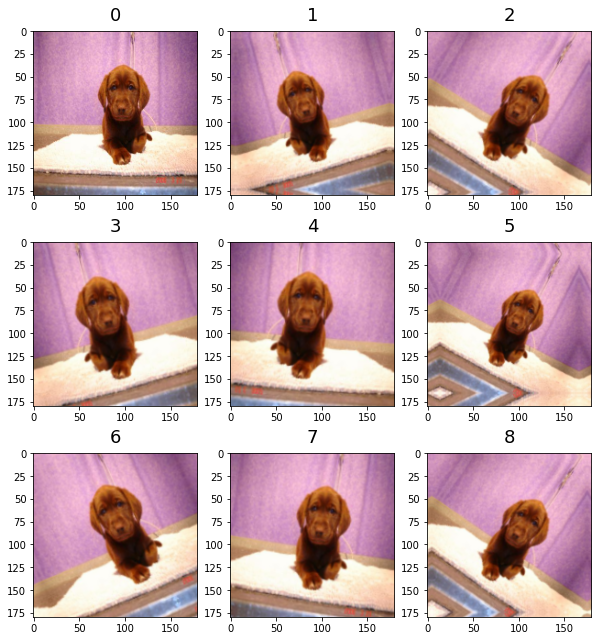

In [6]:
from tensorflow import keras
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom

dt_model = keras.Sequential(
    [
        Rescaling(scale=1.0/255),
        RandomFlip("horizontal"),
        RandomRotation(0.1),
        RandomZoom(0.2),
    ]
)

images_list = []
for images, labels in train_dataset.take(1):
    first_image = images[0].numpy().astype("uint8")
    images_list.append(first_image)
    for i in range(8):
        augmented_image = dt_model(images[0])
        images_list.append(augmented_image)
        
titles = [str(i) for i in range(9)]
showMultipleImages(images_list, titles, (10, 11), 3, 3)

# Treinando o modelo

In [8]:
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom
from tensorflow.keras.layers.experimental.preprocessing import Rescaling

model = keras.Sequential(
    [
        Rescaling(scale=1.0/255),
        RandomFlip("horizontal"),
        RandomRotation(0.1),
        RandomZoom(0.2),
    ]
)

model.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(256, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation="sigmoid"))

model.compile(loss="binary_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

In [9]:
from tensorflow.keras.callbacks import ModelCheckpoint

callbacks = [
    ModelCheckpoint(
        filepath="model_reg.keras",
        save_best_only=True,
        monitor="val_loss"
    )
]

history = model.fit(
    train_dataset,
    epochs=100,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/100
547/547 [==============================] - 36s 61ms/step - loss: 0.8700 - accuracy: 0.6254 - val_loss: 0.5736 - val_accuracy: 0.6932
Epoch 2/100
547/547 [==============================] - 34s 61ms/step - loss: 0.5633 - accuracy: 0.7160 - val_loss: 0.5351 - val_accuracy: 0.7239
Epoch 3/100
547/547 [==============================] - 33s 60ms/step - loss: 0.5156 - accuracy: 0.7552 - val_loss: 0.4383 - val_accuracy: 0.8015
Epoch 4/100
547/547 [==============================] - 33s 60ms/step - loss: 0.4440 - accuracy: 0.8006 - val_loss: 0.5266 - val_accuracy: 0.7369
Epoch 5/100
547/547 [==============================] - 33s 61ms/step - loss: 0.4009 - accuracy: 0.8236 - val_loss: 0.4283 - val_accuracy: 0.8129
Epoch 6/100
547/547 [==============================] - 33s 60ms/step - loss: 0.3584 - accuracy: 0.8439 - val_loss: 0.2862 - val_accuracy: 0.8742
Epoch 7/100
547/547 [==============================] - 34s 62ms/step - loss: 0.3373 - accuracy: 0.8585 - val_loss: 0.3519 - val_ac

# Visualização de Resultados

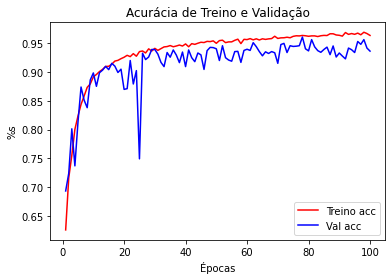

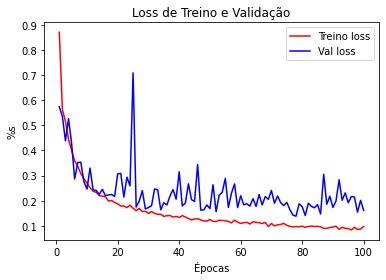

In [16]:
import matplotlib.pyplot as plt
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "r", label="Treino acc")
plt.plot(epochs, val_accuracy, "b", label="Val acc")
plt.xlabel("Épocas")
plt.ylabel("%s")
plt.title("Acurácia de Treino e Validação")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "r", label="Treino loss")
plt.plot(epochs, val_loss, "b", label="Val loss")
plt.xlabel("Épocas")
plt.ylabel("%s")
plt.title("Loss de Treino e Validação")
plt.legend()
plt.show()

# Resultados do Conjunto de Teste

In [11]:
from tensorflow import keras
model = keras.models.load_model("model_reg.keras")

In [17]:
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

158/158 [==============================] - 4s 23ms/step - loss: 0.1510 - accuracy: 0.9555
Test accuracy: 0.955


# Predição Imagem individual

In [13]:
from matplotlib import pyplot as plt

def showSingleImage(img, title, size):
    fig, axis = plt.subplots(figsize = size)

    axis.imshow(img, 'gray')
    axis.set_title(title, fontdict = {'fontsize': 20, 'fontweight': 'medium'})
    plt.show()

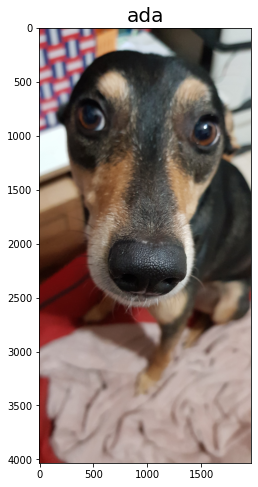

In [18]:
import cv2
img_name = "ada.jpg"
ada_img = cv2.imread(img_name)
ada_img = cv2.cvtColor(ada_img, cv2.COLOR_BGR2RGB)
#ada_img = cv2.resize(ada_img, (180, 180), interpolation = cv2.INTER_AREA)

showSingleImage(ada_img, "ada", (12, 8))

In [19]:
from keras.preprocessing import image
import numpy as np

ada_img = image.load_img(img_name, target_size=(180, 180))
x = image.img_to_array(ada_img)
x = np.expand_dims(x, axis=0)
pred=(model.predict(x) > 0.5).astype('int32')[0][0]

if pred == 1:
    print("Cachorro")
else:
    print("Gato")
    
print(model.predict(x))

Cachorro
[[0.9917949]]


# Referências

* https://machinelearningmastery.com/how-to-develop-a-convolutional-neural-network-to-classify-photos-of-dogs-and-cats/
* https://stackoverflow.com/questions/3430372/how-do-i-get-the-full-path-of-the-current-files-directory
* https://www.geeksforgeeks.org/python-list-files-in-a-directory/
* https://pynative.com/python-random-sample/
* https://machinelearningmastery.com/how-to-develop-a-convolutional-neural-network-to-classify-photos-of-dogs-and-cats/
* https://www.mygreatlearning.com/blog/keras-tutorial/
* https://www.machinecurve.com/index.php/2020/03/30/how-to-use-conv2d-with-keras/
* https://www.pyimagesearch.com/2021/06/30/how-to-use-the-modelcheckpoint-callback-with-keras-and-tensorflow/